C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
The number of classes is: 2 
 The number of channels is 1.
The class_names are {'0': 'normal', '1': 'pneumonia'}
{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'task': 'binary-class', 'label': {'0': 'normal', '1': 'pneumonia'}, 'n_channels': 1, 'n_samples': {'train': 4708, 'val': 524, 'test': 624}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: C:\Users\Theodora\.medmnist\

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


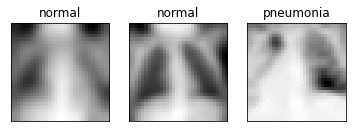

In [1]:
# imports
import torch
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import copy


from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from tqdm import tqdm
import seaborn as sns

from ConvNet import ConvNet, MyDropout
from Model_LeNet import LeNet, MyDropout
from dataset import train_dataset, test_dataset, n_channels, n_classes, class_names
#from test import prediction_list

In [2]:
from test_lenet import prediction_list
preds_lenet = ['pneumonia' if i==1 else 'normal' for i in prediction_list]

binary-class
LeNet
Testing the model


100%|██████████| 624/624 [00:05<00:00, 122.37it/s]

Test accuracy: 86.859%


In [3]:
from test_convnet import prediction_list
preds_convnet = ['pneumonia' if i==1 else 'normal' for i in prediction_list]

binary-class
ConvNet
Testing the model


100%|██████████| 624/624 [00:01<00:00, 412.78it/s]

Test accuracy: 86.058%


In [4]:
model = ConvNet(n_channels, n_classes)
model.load_state_dict(torch.load('../outputs/pneumonia_convnet.ckpt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
def LRP_individual(model, X, gamma = 0.25, device='cpu', dropout=True, verbose=False):
    
    if not dropout:
        model.eval()
    else:
        model.train()
    model.to(device)
    
    # Transform the image X form 1x32x32 to 1x1x32x32 to fit the shape of Conv layers
    X = X.view([1,1,32,32]).to(device)
    # Get the list of layers of the network
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)][1:]
    # Propagate the input
    L = len(layers)
    A = [X]+[X]*L # Create a list to store the activation produced by each layer
    for l in range(L):
        A[l+1] = layers[l].forward(A[l]).to(device)
        #print(type(A[l+1]))
        
    scores = np.array(A[-1].data.view(-1).cpu())
    ind = np.argsort(-scores) # sorts the output classes by max probability: array of 10 indices
    
#     if verbose:
#         for i in ind[:3]:
#             print('New instance')
#             print('%20s (%3d): %6.3f'%(im))
    
    # Get the relevance of the last layer using the highest classification score of the top layer
    T = A[-1].cpu().detach().numpy().tolist()[0]
    index = T.index(max(T))
    T = np.abs(np.array(T))*0
    T[index]=1
    T = torch.FloatTensor(T)
    # Create the list of relevances with (L+1) elements and assign the value of the last one
    R = [None]*L + [(A[-1].cpu()*T).data+1e-6]
    # Propagation procedure from the top-layer towards the lower layers
    for l in range(0,L)[::-1]:
        A[l] = A[l].data.requires_grad_(True)
        if isinstance(layers[l], torch.nn.MaxPool2d) : layers[l] = torch.nn.AvgPool2d(2)
        if isinstance(layers[l], torch.nn.Conv2d) or \
        isinstance(layers[l], torch.nn.AvgPool2d) or \
        isinstance(layers[l], torch.nn.Linear) or \
        isinstance(layers[l], torch.nn.Flatten):
            # Specifies the rho function that will be applied to the weights of the layer
            if 0<l<=13: #Gamma rule(LRP-gamma)
                rho = lambda p: p+gamma*p.clamp(min=0)    #0.25:gamma
            else: # Basic rule (LRP-0)                   #clamp(min=0): puts all the values that are <=0 equal to 0
                rho = lambda p: p                        # keeps only the positive parameter θ
            
            
            # Step 1: Transform the weights of the layer and executes a forward pass
            z = newlayer(layers[l], rho).forward(A[l])+1e-9
            # Step 2: Element-wise division between the relevance of the next layer and the denominator
            s = (R[l+1].to(device)/z).data
            # Step 3: Calculate the gradient and multiply it by the activation layer 
            (z*s).sum().backward()
            c = A[l].grad
            R[l] = (A[l]*c).cpu().data
            
        else:
            if not dropout:
                R[l] = R[l+1]
            else:
                if isinstance(layers[l],MyDropout):
                    if 0<l<=13:
                        rho = lambda p: p+0.25*clamp(min=0)
                    else:
                        rho = lambda p: p
                        
                    z = newlayer(layers[l], rho).forward(A[l], freeze = True)+1e-9
                    s = (R[l+1].to(device)/z).data
                    (z*s).sum().backward()
                    c = A[l].grad
                    R[l] = (A[l]*c).data()
                else:
                    R[l] = R[l+1]
                            
    # Return the relevance of the input layer        
    return R[0]
        
def newlayer(l,g):
    '''Clone a layer and pass its parameters through the function g'''
    layer = copy.deepcopy(l)
    try: layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError: pass
    
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

In [13]:
# Function for MinMax Normalisation of Relevances

def normalise_relevance(relevance_matrix):
    a = relevance_matrix.min()
    b = relevance_matrix.max()
    
    if (a==0.)  & (b==0.):
        return relevance_matrix
    if (a>0.):
        return (relevance_matrix>0.)*relevance_matrix/b
    if (b<0.):
        return ~ (relevance_matrix <=0.)*relevance_matrix/a
    
    return (relevance_matrix >0.)*relevance_matrix/b - (relevance_matrix <=0.)*relevance_matrix/a

[574 588 504 323 211]


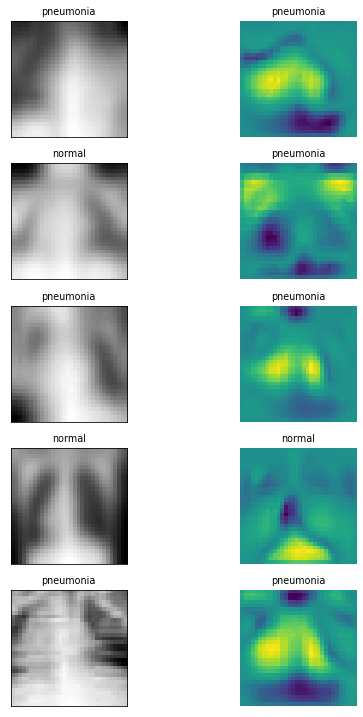

In [35]:
#np.random.seed(2023)
samples= np.random.choice(len(test_dataset), 5)
counter = 0
Standard_LRPs = torch.zeros([len(samples), 32, 32])
for q in samples:
    Standard_LRPs[counter] = LRP_individual(model, test_dataset[q][0], gamma = 0.25, dropout = False)
    counter += 1

print(samples)
I = len(samples)
#alphas = [5,25,50,75,95]

matplotlib.rcParams.update({'font.size':8})
fig, ax = plt.subplots(I,2, figsize=(8, 10))

cols = ['Original\nImage', 'Standard\nLRP']
for axe, col in zip(ax[0], cols):
    axe.set_title(col)
    
for i in range(I):
    img = test_dataset[samples[i]][0][0]
    lab = test_dataset[samples[i]][1][0]
    ax[i][0].imshow(img.cpu(), cmap = 'gray')
    ax[i][0].set_title(class_names[f"{lab}"])
    ax[i][0].xaxis.set_major_locator(plt.NullLocator())
    ax[i][0].yaxis.set_major_locator(plt.NullLocator())
    
    
    ax[i][1].imshow(normalise_relevance(Standard_LRPs[i].cpu()), cmap='viridis')
    ax[i][1].set_title(preds_convnet[samples[i]])
    ax[i][1].xaxis.set_major_locator(plt.NullLocator())
    ax[i][1].yaxis.set_major_locator(plt.NullLocator())
    
    ax[i][1].set_axis_off()

plt.tight_layout()
plt.show()

In [15]:
# Function for performing a pixel flipping

def pixelflipping(image, class_ind, R, model, inner_steps, step_size):
    
    # image: Original image
    # Class_ind: index of a true class
    # R :        Relevances
    # model:     Neural Network
    # inner_steps: Number of times we evaluate scores on the augmented image
    # step_size: Number of pixels flipped between the evaluations
    
    img = image.clone()
    relevances = R.clone()
    scores = torch.zeros(inner_steps)
    
    for i in range(inner_steps):
        model.eval()
        scores[i] = model(img.view([1,1,32,32]))[0][class_ind].data
        for s in range(step_size):
            ind = np.unravel_index(torch.argmax(relevances).cpu(), relevances.shape)
            img[0][ind[2]][ind[3]] = (np.random.uniform(0,1,1)[0] - .5)/0.5
            relevances[ind] = -np.Inf
    return scores

In [36]:
# Parameters:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

N_pics = len(test_dataset)  # Number of images used in pixel flipping
N_inner = 64                # Number of times we evaluate scores on the augmented image
steps = 4                   # Number of pixels flipped between the evaluations

score_lrp = torch.zeros([N_pics, N_inner]).data.to(device)
score_random = torch.zeros([N_pics, N_inner]).data.to(device)

#model.to(device)

for q in tqdm(range(N_pics)):
    
    img = test_dataset[q][0]
    class_ind = test_dataset[q][1]

    LRP = LRP_individual(model, test_dataset[q][0], dropout = False)
    score_lrp[q] = pixelflipping(img, class_ind, LRP, model, N_inner, steps)

100%|██████████| 624/624 [01:30<00:00,  6.93it/s]


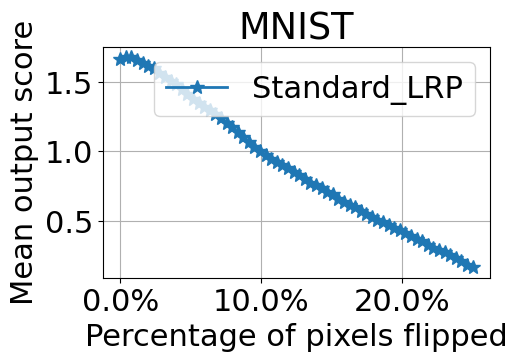

In [37]:
# Visualising the performance of pixel flipping

plt.style.use('default')

matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(5,3), num='seaborn')

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

x = np.linspace(0, 100*(N_inner*steps/32/32), N_inner)
ax.grid(True, which='both', ls = '-')
ax.set_ylabel('Mean output score')
ax.set_xlabel('Percentage of pixels flipped')
ax.set_title('MNIST')

ax.plot(x, score_lrp.cpu().mean(axis=0).detach().numpy(), label = 'Standard_LRP', linewidth = 2, markersize=10, marker = '*')
ax.legend()
plt.show()

In [38]:
def pixel_flipping_both(image, R, model, inner_steps, step_size):
    img = image.clone()
    relevances = R.clone()
    scores = torch.zeros([inner_steps, 2])
    scores_c = torch.zeros(inner_steps)
    scores_w = torch.zeros(inner_steps)
    
    for i in range(inner_steps):
        model.eval()
        scores[i] = model(img.view([1,1,32,32]))[0].data
        scores_c[i] = scores[i][class_ind]
        scores_w[i] = scores[i][1-class_ind]
        for s in range(step_size):
            ind = np.unravel_index(torch.argmax(relevances).cpu(), relevances.shape)
            img[0][ind[2]][ind[3]] = (np.random.uniform(0,1,1)[0]-.5)/0.5
            relevances[ind] = -np.Inf
    return scores, scores_c, scores_w

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_pics = len(test_dataset)
N_inner = 128
steps = 4
scores_lrp = torch.zeros([N_pics, N_inner, 2]).data.to(device)
scores_lrp_c = torch.zeros([N_pics, N_inner]).data.to(device)
scores_lrp_w = torch.zeros([N_pics, N_inner]).data.to(device)

for q in tqdm(range(N_pics)):
    image = test_dataset[q][0]
    class_ind = test_dataset[q][1]
    LRP = LRP_individual(model, test_dataset[q][0], dropout = False)
    scores_lrp[q], scores_lrp_c[q], scores_lrp_w[q] = pixel_flipping_both(image, LRP, model, N_inner, steps)

100%|██████████| 624/624 [03:00<00:00,  3.46it/s]


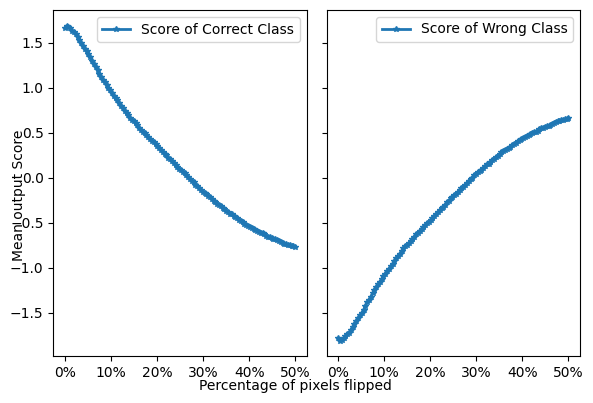

In [66]:
# Visualising the performance of pixel flipping 

plt.style.use('default')

matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1,2, figsize=(6,4), sharex = True, sharey = True, num='seaborn')
ax.flatten()

ax[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax = 100))

x = np.linspace(0, 100*(N_inner*steps/32/32), N_inner)
# ax[0].set_ylabel('Mean output score')
# ax[0].set_xlabel('Percentage of pixels flipped')

ax[0].plot(x, scores_lrp_c.cpu().mean(axis=0).detach().numpy(), label = 'Score of Correct Class', linewidth=2, markersize=4, marker='*')
ax[0].legend()


ax[1].plot(x, scores_lrp_w.cpu().mean(axis=0).detach().numpy(), label = 'Score of Wrong Class', linewidth=2, markersize = 4, marker='*')
ax[1].legend()
#{'bottom', 'baseline', 'center', 'center_baseline', 'top'}

fig.text(0.5, 0.04, 'Percentage of pixels flipped', va='top', ha='center')
fig.text(0.04, 0.5, 'Mean output Score', va='center', ha='center', rotation='vertical')
fig.tight_layout()
plt.legend()
plt.show()